In [1]:
import numpy as np
import pandas as pd
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import spconv.pytorch as spconv
import matplotlib.pyplot as plt
import mytools
import mymodels

# Prepare Data

In [2]:
# Read pandas dataframe with all information about sparse training tensors
st_info = pd.read_pickle('/home/majd/sparse_training_tensors_test/sparse_tensor_info.pk')
st_info.head()

,dir,offset,diff,energy
0,"[0.026361450114195585, 0.8711186313268745, -0....","[0.3281184960483522, -2.4369016024112162, -0.1...",0.017067,50
1,"[0.46959426569273266, 0.811740192412494, -0.34...","[-2.7931684707802567, -2.6652880089994215, -0....",0.039308,50
2,"[-0.15171981821024536, -0.8855858913527752, 0....","[-1.1201619593568408, 2.5015106225271837, 0.26...",0.041201,50
3,"[0.21180233188851963, 0.08083834636858116, 0.9...","[1.2717487893835637, -1.7885720595904964, -2.3...",0.018807,50
4,"[0.9167803756423292, -0.39745952868971435, -0....","[-2.753222599501232, -0.5248287871094732, -0.8...",0.027700,50


In [3]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_training_tensors_test/', st_info=st_info)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(MyDataset,[0.8, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))

# Create training and validation DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training samples:  131055
Validation samples:  32763


In [4]:
# Print tensor shapes
for X_plot, y_plot, offset_plot in train_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])


In [5]:
#Record shape of voxel grid
grid_shape = X_plot.shape[1:4]
print("Voxel grid shape: " , grid_shape)

Voxel grid shape:  torch.Size([120, 120, 120])


# Visualize a sample

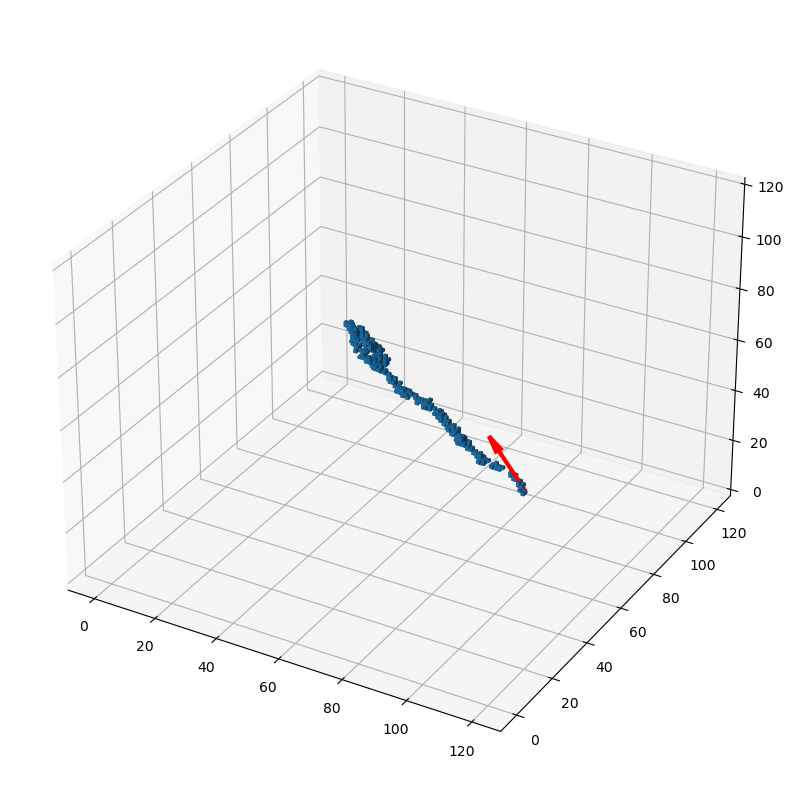

In [6]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = mytools.voxel_grid['eff_l']
# Voxel size in cm
vox_l = mytools.voxel_grid['vox_l']

#Convert to dense, reshape and convert to numpy
X_plot = X_plot.to_dense().reshape(-1, 1, 120, 120, 120).numpy()

index = 2
mytools.plot_tensor_dir(tensor = X_plot[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)



# Initialize Convnet

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

model = mymodels.spConvnet(shape = grid_shape ).to(device)
print(model)

Using cuda device
spConvnet(
  (net): SparseSequential(
    (0): SparseConv3d(1, 50, kernel_size=[6, 6, 6], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (1): ReLU()
    (2): SparseMaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], algo=ConvAlgo.MaskImplicitGemm)
    (3): SparseConv3d(50, 30, kernel_size=[4, 4, 4], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (4): ReLU()
    (5): SparseConv3d(30, 20, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
    (6): ReLU()
    (7): SparseMaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], algo=ConvAlgo.MaskImplicitGemm)
    (8): ToDense()
  )
  (fc1): Linear(in_features=34560, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bi

# Train the model

In [8]:
# Specify optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.0001, betas=(0.94, 0.999), eps=1e-07)


In [9]:
# Implement early stopping in training loop
# Stop if validation loss has not decreased for the last [patience] epochs
# The model with the lowest loss is stored
patience = 2

Training_losses = np.array([])
Validation_losses = np.array([])

epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    Training_losses = np.append(Training_losses, mytools.train(train_dataloader, model, mytools.CSloss, optimizer, device))
    Validation_losses = np.append(Validation_losses, mytools.validate(val_dataloader, model, mytools.CSloss, device))
    
    # Keep a running copy of the model with the lowest loss
    if Validation_losses[-1] == np.min(Validation_losses):
        final_model = copy.deepcopy(model)
    
    if len(Validation_losses) > patience:
        if np.sum((Validation_losses[-1*np.arange(patience)-1] - Validation_losses[-1*np.arange(patience)-2]) < 0) == 0:
            print("Stopping early!")
            break
            
print("Done!")

Epoch 1
-------------------------------
Current batch training loss: 0.002314  [    0/131055]
Current batch training loss: -0.334067  [ 6400/131055]
Current batch training loss: -0.334332  [12800/131055]
Current batch training loss: -0.364817  [19200/131055]
Current batch training loss: -0.428580  [25600/131055]
Current batch training loss: -0.346668  [32000/131055]
Current batch training loss: -0.505213  [38400/131055]
Current batch training loss: -0.483693  [44800/131055]
Current batch training loss: -0.465682  [51200/131055]
Current batch training loss: -0.524037  [57600/131055]
Current batch training loss: -0.493316  [64000/131055]
Current batch training loss: -0.521909  [70400/131055]
Current batch training loss: -0.557658  [76800/131055]
Current batch training loss: -0.609456  [83200/131055]
Current batch training loss: -0.672300  [89600/131055]
Current batch training loss: -0.621683  [96000/131055]
Current batch training loss: -0.682047  [102400/131055]
Current batch training lo

# Visualize Training

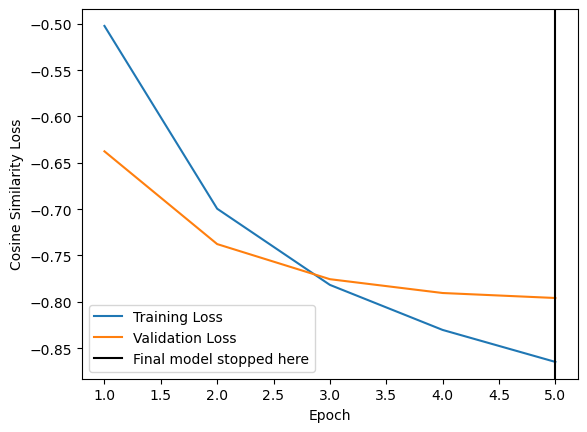

In [12]:
# Plot Training and Validation Loss
# Indicate where the final model stopped training

best_epoch = np.argmin(Validation_losses)+1

plt.plot(np.arange(len(Training_losses))+1,Training_losses,label="Training Loss")
plt.plot(np.arange(len(Validation_losses))+1,Validation_losses,label="Validation Loss")
plt.axvline(best_epoch,label="Final model stopped here",color='k')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity Loss')
plt.legend()


# Save the Model

In [11]:
torch.save(final_model, "../3D_Heteroscedastic_Convnet_models/3D_CNN_spconv.pt")
print("Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_CNN_spconv.pt")

Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_CNN_spconv.pt
